# Data Challenge - Divvy dataset (Alan Au)

### Data

Divvy is a bike-sharing program sponsored by the City of Chicago since 2013.  They have made all of their bike ride data freely available online at https://www.divvybikes.com/system-data.  We’d like to learn about this data — in particular, we are interested in short rides — we’ll define “short” as rides in which the direct distance between the departure and arrival stations is less than 2km.

Each trip is anonymized and includes:

* Trip start day and time
* Trip end day and time
* Trip start station
* Trip end station
* Rider type (Member or 24-Hour Pass User)
* If a Member trip, it will also include Member’s gender and year of birth

### Task

Build a model to predict if a given bike trip will be a short one or not.  You are free to use as much of the Divvy data as you deem appropriate.  But do validate, and don’t overfit.  Moreover, time permitted, please feel free to bring in any publicly available supplementary data that might be useful.  Be careful not to bring in the time machine, i.e., any information that would not be known to Divvy at the start of a trip! Please code your solution in Python.

 

### What Are We Looking For?

We are looking for a finished predictive model using whatever tools and libraries that you are comfortable with.  In your submission, please document your methodology (with visualizations where appropriate) and provide ALL the code (including any environment setup and data sources) necessary to reproduce your analysis from scratch. Moreover, please report on the general performance of your model.

In [1]:
#!/usr/bin/python3
__author__ = 'Alan Au'
__date__   = '2018-12-29'

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import time
import datetime
import random
import pickle

from os import listdir
from string import digits as digits # saves me some typing

#Instead of manually typing in file names, I'll just let Python find them for me.

data_loc = "./Divvy/" #path to my data file subdirectory; must end with '/'

trip_files = [f for f in listdir(data_loc) if f[6:11] == 'Trips' and f[-4:] == ".csv"]
station_files = [f for f in listdir(data_loc) if f[6:14] == 'Stations' and f[-4:] == ".csv"]

#seed = int(random.random()*10000) #generate a random number between 0 and 10000
seed = 5296
print("Pseudorandom seed is:",seed)

Pseudorandom seed is: 5296


In [2]:
#This is a haversine distance calculator. I pulled it from https://pypi.python.org/pypi/haversine
    
from math import radians, cos, sin, asin, sqrt

AVG_EARTH_RADIUS = 6371 # in km
MILES_PER_KILOMETER = 0.621371

def haversine(point1, point2, miles=False):
    # unpack latitude/longitude
    lat1, lng1 = point1
    lat2, lng2 = point2

    # convert all latitudes/longitudes from decimal degrees to radians
    lat1, lng1, lat2, lng2 = map(radians, (lat1, lng1, lat2, lng2))

    # calculate haversine
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = sin(lat * 0.5) ** 2 + cos(lat1) * cos(lat2) * sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * asin(sqrt(d))
    if miles:
        return h * MILES_PER_KILOMETER # in miles
    else:
        return h # in kilometers

# Data preparation (jump to "Data ingestion" if re-running)

The first step is to download and extract the data files of interest (from the URL in the problem statement above). There is both station and trip data.

Some notes:
* 2013 has a different date format, but that's the only file, so I can just transform it and dump it back out.
* Some of the files wrap the data elements in quotation marks, so I will want to strip those off.
* Other than those differences, the files seem compatible (if large).

### First let's process the stations, so I can get the lat/long and calculate distances.

In [3]:
#Fields are:
#id,name,city (2017 only),latitude,longitude,dpcapacity,landmark (2013 only),online date
#I'm going to discard the name, city, dpcapacity, landmark, and online date.

start = time.mktime(time.localtime())
print("Running...") #so I know Jupyter is doing something

#for stations
def combine_stations(data_loc, stations, out_file):
    #inputs: data_loc (directory), stations (list of filenames), out_file (filename)
    #outputs: writes to out_file, returns all_stations (dict)
    combined_file = open(data_loc+out_file,'w')
    all_stations = {}
    for station in stations:
        raw_file = open(data_loc+station,'r')
        raw_data = raw_file.readlines()
        year = station[15:19] #pull from filename
        if year not in all_stations:
            all_stations[year] = {}
        for line in raw_data:
            line = line.replace('\"','') #get rid of quotation marks

            if line[0] not in digits: #skip header lines
                continue
            
            if year == '2017': #2017 only
                (s_id, s_name, s_city, s_lat, s_long) = line.split(',')[:5]
            else:
                (s_id, s_name, s_lat, s_long) = line.split(',')[:4]
            if s_id not in all_stations[year]: #store stations by year; they sometimes get moved
                all_stations[year][s_id] = (float(s_lat),float(s_long))
                combined_file.write(','.join([year,s_id,s_lat,s_long])+'\n')
    combined_file.close()
    return all_stations #{year:{id:(lat, long)}}

stations = combine_stations(data_loc, station_files, "All_Stations.csv")

duration = time.mktime(time.localtime()) - start
print("All stations done! Finished in "+str(duration)+" seconds.") #so I know when Jupyter is done (takes about 1 sec.)

Running...
All stations done! Finished in 0.0 seconds.


### Now let's handle trip data.

Since I have to look at all of the dates anyways, I might as well decompose the date into features that might be useful for modeling. Specifically, I will probably want the day-of-year, the weekday, and the hour associated with a trip's start and stop. This attempts to account for yearly, weekly, and daily patterns of travel.

In [4]:
#helper functions
def new_2013_date(old_date):
    #old format is yyyy-mm-dd hh:mm
    #new format is mm/dd/yyyy hh:mm
    parts = old_date.split()
    (y,m,d) = parts[0].split('-')
    new_date = '/'.join([m,d,y])+" "+parts[1]
    return new_date

def process_date(date):
    #input: mm/dd/yyyy hh:mm
    parts = date.split()
    (m,d,y) = list(map(int,parts[0].split('/')))
    day_of_year = str(datetime.datetime(y, m, d).timetuple().tm_yday)
    weekday = str(datetime.datetime(y, m, d).weekday()) #Monday = 0, etc.
    hour = parts[1].split(':')[0] #get the first part of hh:mm
    return (day_of_year, weekday, hour)

testdate = "2017-12-29 14:30" #Friday
testdate = new_2013_date(testdate)
print(testdate, process_date(testdate))

12/29/2017 14:30 ('363', '4', '14')


In [5]:
#Fields are:
#trip_id,start,stop,bike,duration,from_id,from_name,to_id,to_name,usertype,gender,birthyear

#for trips
def combine_trips(data_loc, trips, stations, out_file):
    #inputs: data_loc (directory), trips (list of filenames), out_file (filename)
    #outputs: writes to out_file, returns none
    combined_file = open(data_loc+out_file,'w')
    
    header = "year,start_day,start_weekday,start_hour,stop_day,stop_weekday,stop_hour,bike,duration,from_id,to_id,distance,short,usertype,gender,birthyear\n"
    combined_file.write(header)
    for trip in trips:
        year = trip[12:16] #from filename
        raw_file = open(data_loc+trip,'r')
        raw_data = raw_file.readlines()
        for line in raw_data:
            line = line.strip().replace('\"','') #get rid of quotation marks

            if line[0] not in digits: #skip header lines
                continue

            (t_id,t_start,t_stop,t_bike,t_dur,t_from_id,t_from_name,t_to_id,t_to_name,t_usertype,t_gender,t_birth) = line.split(',')
            
            if year == '2013': #process 2013 dates separately
                t_start = new_2013_date(t_start)
                t_stop = new_2013_date(t_stop)

            t_start_doy,t_start_weekday,t_start_hour = process_date(t_start)
            t_stop_doy,t_stop_weekday,t_stop_hour = process_date(t_stop)
                        
            t_dist = '0'
            try:
                t_dist = str(haversine(stations[year][t_from_id],stations[year][t_to_id])) #calculate distance between stations in km
            except KeyError:
                t_dist = str(haversine(stations['2017'][t_from_id],stations['2017'][t_to_id])) #if not found, try most recent station list
                #t_dist = str(float(t_dur)/360) #estimated distance based on 10km/h speed

            t_short = '0'
            if float(t_dist) < 2.0: 
                t_short = '1'
            
            #I'm throwing out trip_id (probably not useful) and station names (redundant w/station ID)
            out_line = ','.join([year, t_start_doy,t_start_weekday,t_start_hour,
                                 t_stop_doy,t_stop_weekday,t_stop_hour,
                                 t_bike,t_dur,t_from_id,t_to_id,t_dist,t_short,t_usertype,t_gender,t_birth])+"\n"
            combined_file.write(out_line)
    combined_file.close() #clean up after ourselves

### Now let's actually process the input files.

Note: Don't need to actually run this each time (it takes about 10 minutes). It generates a file "All_Trips.csv" which I can just import into future sessions. 

**Uncomment out the combine_trips call if you want to re-run this.**

In [73]:
start = time.mktime(time.localtime())
print("Running...") #so I know Jupyter is doing something

#combine_trips(data_loc, trip_files, stations, "All_Trips.csv") #Commented out so I don't accidentally re-run it

duration = time.mktime(time.localtime()) - start
print("All trips done! Finished in "+str(duration)+" seconds.") #so I know when Jupyter is done (takes about 600 sec.)

Running...
All trips done! Finished in 597.0 seconds.


Here's some code to subset out by year, in case I want smaller test sets to play around with. Ideally I want to just use the entire dataset, but this way I can try testing things out on smaller subsets of the data. It generates a set of "Trip_YYYY.csv" files. 

**As above, uncomment out the combine_trips call if you want to re-run this.**

In [9]:
start = time.mktime(time.localtime())
print("Running...") #so I know Jupyter is doing something

all_trips = {}
for trip_file in trip_files:
    year = trip_file[12:16] #get the year number
    if year in all_trips:
        all_trips[year].append(trip_file)
    else:
        all_trips[year] = [trip_file]

for trip_year in all_trips: #for each year, process its sublist of associated files
    out_name = "Trips_"+trip_year+".csv"
    #combine_trips(data_loc, all_trips[trip_year], stations, out_name) #Commented out so I don't accidentally re-run it

duration = time.mktime(time.localtime()) - start
print("Trips-by-year done! Finished in "+str(duration)+" seconds.") #so I know when Jupyter is done (takes about 570 sec.)

Running...
Trips-by-year done! Finished in 564.0 seconds.


# Data ingestion

Now I have a data file in a standardized format, with distance between stations and a set of features. 

1. year (2013-2017)
2. start day-of-year (1-366)
3. start weekday (0-6, starts on Monday)
5. start hour (0-23)
6. stop day-of-year (1-366)
7. stop weekday (0-6, starts on Monday)
8. stop hour (0-23)
9. bike id (integer)
10. trip duration (seconds)
11. from station (integer)
12. to station (integer)
13. trip distance (km)
14. short trip ('1' if distance < 2.0 km)
15. user type ('Customer' or 'Subscriber')
16. gender (if 'Subscriber')
17. birth year (if 'Subscriber')

In [2]:
filename = "All_Trips.csv"

start = time.mktime(time.localtime())
print("Running...") #so I know Jupyter is doing something

df = pd.read_csv(data_loc+filename, low_memory=False) #data_loc is from above
trip_count = df['short'].count()

duration = time.mktime(time.localtime()) - start
print("Data ingestion done! Finished in "+str(duration)+" seconds.") #so I know when Jupyter is done (takes about 30 sec.)

df.head(3)

Running...
Data ingestion done! Finished in 26.0 seconds.


,year,start_day,start_weekday,start_hour,stop_day,stop_weekday,stop_hour,bike,duration,from_id,to_id,distance,short,usertype,gender,birthyear
0,2013,178,3,12,178,3,12,480,316,85,28,2.223265,0,Customer,NaN,NaN
1,2013,178,3,14,178,3,14,77,64,32,32,0.000000,1,Customer,NaN,NaN
2,2013,178,3,14,178,3,15,77,433,32,19,0.667182,1,Customer,NaN,NaN


# Basic data visualization


In [4]:
#check for missing/NaN values

df.count()

year             11544749
start_day        11544749
start_weekday    11544749
start_hour       11544749
stop_day         11544749
stop_weekday     11544749
stop_hour        11544749
bike             11544749
duration         11544749
from_id          11544749
to_id            11544749
distance         11544749
short            11544749
usertype         11544749
gender            8291460
birthyear         8291991
dtype: int64

In [5]:
short_count = sum(df['short'])
long_count = trip_count - short_count
short_pct = short_count/trip_count

print("Total trips:", trip_count)
print("Short trips:", short_count)
print("Long trips: ", long_count)
print("Short/total trips:", '{:.2f}'.format(short_pct))

Total trips: 11544749
Short trips: 7234994
Long trips:  4309755
Short/total trips: 0.63


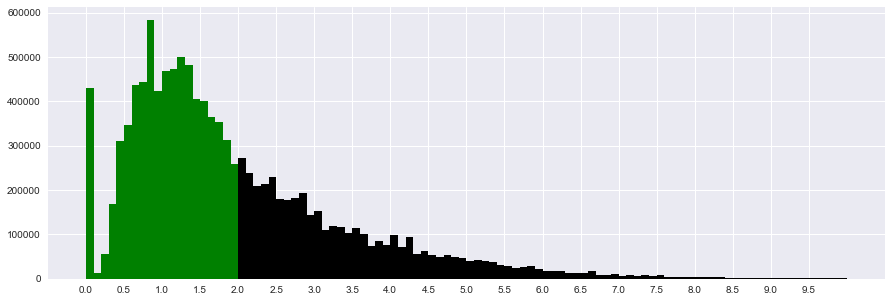

In [7]:
#Histogram of distances
#Note: do this before removing the "distance" column from the dataframe

plt.rcParams["figure.figsize"] = [15,5] #resize the plot for easy display

#sns.distplot(raw_df['distance'], kde=False) #seaborn version

max_dist = 10
cutoff_dist = 2
all_dist = list(map(lambda x:x/10,range(0,max_dist*10+1)))
short_dist = list(map(lambda x:x/10,range(0,cutoff_dist*10+1)))

plt.figure().add_subplot(111).set_xticks(list(map(lambda x:x/2,range(0,max_dist*2))))

plt.hist(df['distance'], bins = all_dist, rwidth = 1.0, color = 'k');
plt.hist(df['distance'], bins = short_dist, rwidth = 1.0, color = 'g');

### Some initial observations

* So far, this looks pretty good. There are about 11.5 Million trip records. 63% of them are short trips (< 2km), so the dataset isn't perfectly balanced, but it's not too skewed either.

* Some trips start and stop at the same station. I could estimate distance based on duration, but the problem asks for straight-line distances calculated between stations, so I'll just leave it alone for now.

* Trips generally start and stop on the same day, so I only really need either the start or the stop datetime information. Speaking of which, the year probably isn't useful as a model input.

* If I have both the start and stop locations, I can just calculate the distance and don't need a predictive model. I should use one or the other. Start location is probably more useful, since it may have more impact on a customer's decision to use the service (bike availability, condition, messaging, convenience, etc.).

# More data visualization

Now I'm going to do some quick visualizations to see what the data looks like.

In [8]:
#encode usertype and check numbers on Subscribers vs. Customers, 
#There's apparently a third value: 'Dependent' which is a minor paid for by a subscriber

def encode_subscribers(value):
    if not value: return 0
    elif value == 'Customer': return 0
    elif value == 'Subscriber' or value == 'Dependent': return 1
    else: return value

df['usertype'] = df['usertype'].apply(encode_subscribers)    
df['minutes'] = df['duration']//60

short_df = df[df['short']==1]

sub_count = sum(df['usertype'])
print("Total trips:", trip_count)
print("Subscriber trips:", sub_count)
print("Subscriber/total:", '{:.2f}'.format(sub_count/trip_count))

Total trips: 11544749
Subscriber trips: 8291238
Subscriber/total: 0.72


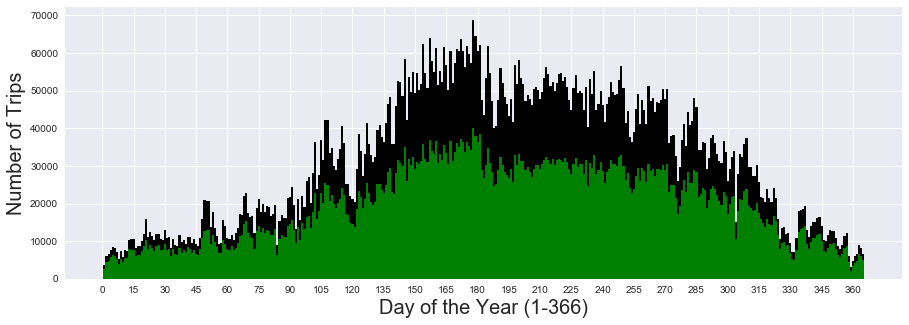

In [6]:
#Histogram of trips by day of year

plt.rcParams["figure.figsize"] = [15,5] #resize the plot for easy display

#sns.distplot(df['start_day'], kde=False) #seaborn version

plt.figure().add_subplot(111).set_xticks(range(0,366,15))

plt.hist(df['start_day'], bins = np.arange(1,367)-0.5, rwidth = 1.0, color = 'k');
plt.hist(short_df['start_day'], bins = np.arange(1,367)-0.5, rwidth = 1.0, color = 'g');

plt.xlabel('Day of the Year (1-366)', fontsize = '20');
plt.ylabel('Number of Trips', fontsize = '20');

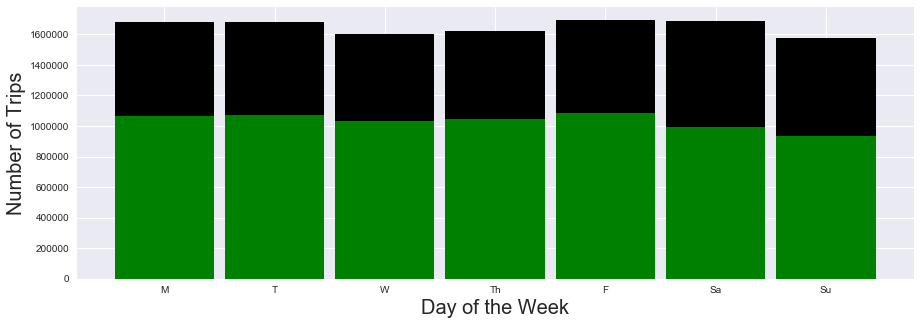

In [13]:
#Histogram of trips by day of week

plt.rcParams["figure.figsize"] = [15,5] #resize the plot for easy display

#sns.distplot(df['start_weekday'], kde=False) #seaborn version

plt.hist(df['start_weekday'], bins = np.arange(0,8)-0.5, rwidth = 0.9, color = 'k');
plt.hist(short_df['start_weekday'], bins = np.arange(0,8)-0.5, rwidth = .9, color = 'g');
weekdays = ['M','T','W','Th','F','Sa','Su']
plt.xticks(range(7), weekdays);

plt.xlabel('Day of the Week', fontsize = '20');
plt.ylabel('Number of Trips', fontsize = '20');

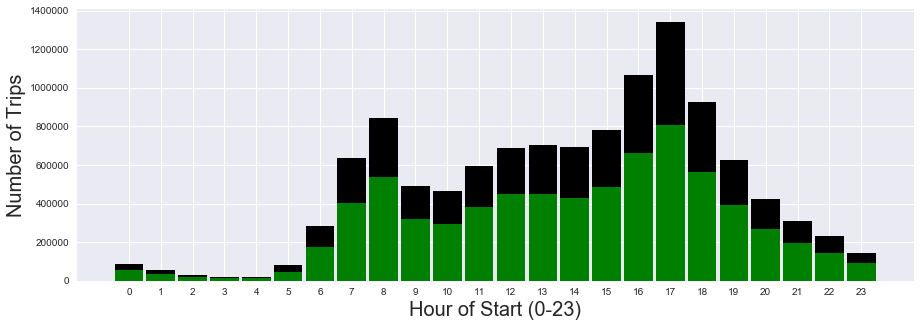

In [14]:
#Histogram of trips by starting hour

plt.rcParams["figure.figsize"] = [15,5] #resize the plot for easy display

#sns.distplot(df['start_hour'], kde=False) #seaborn version

plt.figure().add_subplot(111).set_xticks(range(0,24,1))

plt.hist(df['start_hour'], bins = np.arange(0,25)-0.5, rwidth = 0.9, color = 'k');
plt.hist(short_df['start_hour'], bins = np.arange(0,25)-0.5, rwidth = 0.9, color = 'g');

plt.xlabel('Hour of Start (0-23)', fontsize = '20');
plt.ylabel('Number of Trips', fontsize = '20');

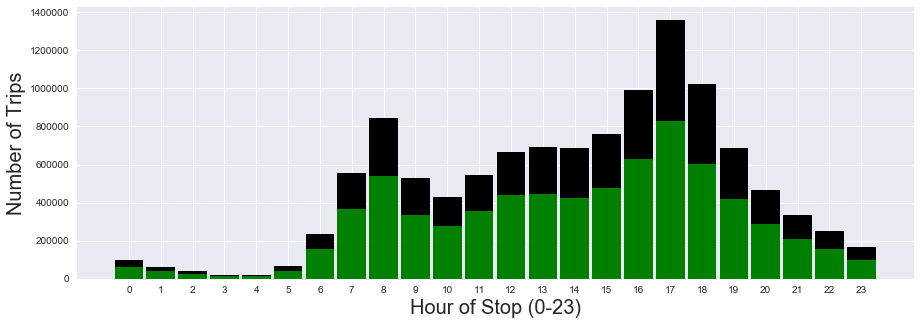

In [8]:
#Histogram of trips by stopping hour

plt.rcParams["figure.figsize"] = [15,5] #resize the plot for easy display

#sns.distplot(df['stop_hour'], kde=False) #seaborn version

plt.figure().add_subplot(111).set_xticks(range(0,24,1))

plt.hist(df['stop_hour'], bins = np.arange(0,25)-0.5, rwidth = 0.9, color = 'k');
plt.hist(short_df['stop_hour'], bins = np.arange(0,25)-0.5, rwidth = 0.9, color = 'g');

plt.xlabel('Hour of Stop (0-23)', fontsize = '20');
plt.ylabel('Number of Trips', fontsize = '20');

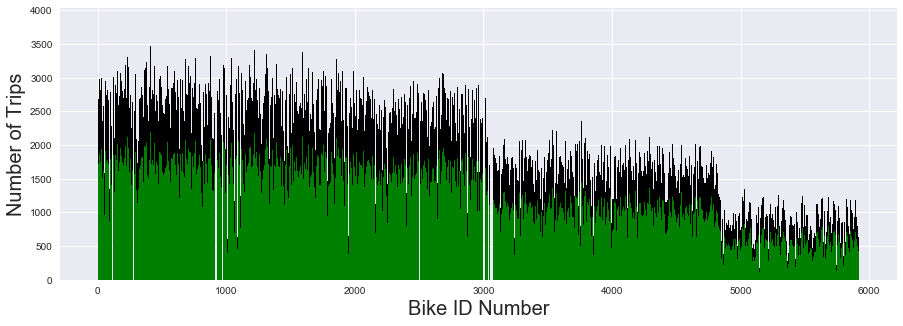

In [16]:
#Histogram of trips by bike number

plt.rcParams["figure.figsize"] = [15,5] #resize the plot for easy display

#sns.distplot(df['bike'], kde=False) #seaborn version

maxbike = max(df['bike'])
plt.hist(df['bike'], bins = np.arange(0,maxbike)-0.5, rwidth = 1.0, color = 'k');
plt.hist(short_df['bike'], bins = np.arange(0,maxbike)-0.5, rwidth = 1.0, color = 'g');

plt.xlabel('Bike ID Number', fontsize = '20');
plt.ylabel('Number of Trips', fontsize = '20');

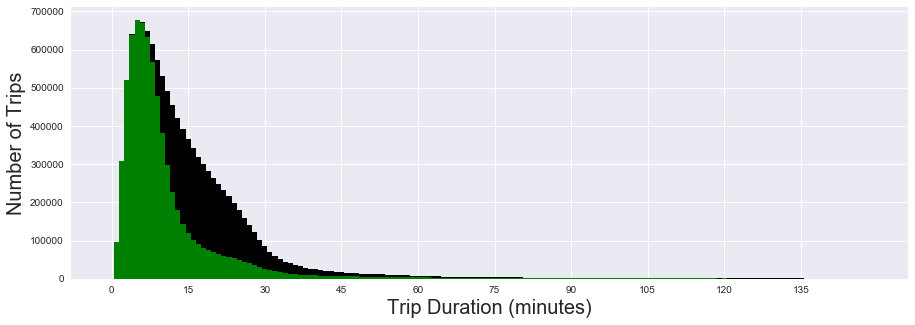

In [16]:
#Histogram of trips by number of minutes

plt.rcParams["figure.figsize"] = [15,5] #resize the plot for easy display

#sns.distplot(df['minutes'], kde=False) #seaborn version

#maxdur = max(df['minutes']) #in minutes
maxdur = 150 #there's an outlier in the dataset; use 150 minutes instead

plt.figure().add_subplot(111).set_xticks(range(0,maxdur,15))

plt.hist(df['minutes'], bins = np.arange(0,maxdur)-0.5, rwidth = 1.0, color = 'k');
plt.hist(short_df['minutes'], bins = np.arange(0,maxdur)-0.5, rwidth = 1.0, color = 'g');

plt.xlabel('Trip Duration (minutes)', fontsize = '20');
plt.ylabel('Number of Trips', fontsize = '20');

While there are usage spikes during the summer months and during commute hours, there's a good mixture of both short and long trips associated with each input feature.


# Data modeling

Let's try building some models. Because we're looking for a binary categorical output, I'll start with a simple logistic regression model.

To start, I'm going to remove the year, the bike ID, and the subscriber-only information (gender, birthyear).

I'm also going to take out the stop information and the trip duration, which we wouldn't be able to determine until after the ride was completed.

In [17]:
model_df = df.drop(['year','stop_day','stop_weekday','stop_hour','bike','duration','minutes','to_id','distance','gender','birthyear'],axis=1)

#verify that the dataframe is set up properly
model_df.head(3)

,start_day,start_weekday,start_hour,from_id,short,usertype
0,178,3,12,85,0,0
1,178,3,14,32,1,0
2,178,3,14,32,1,0


First I'm going to split the dataset into training and test sets. 20% should do it. 

The data isn't particularly imbalanced in any one area, and I have plenty of datapoints, so I'm not too concerned with needing to stratify my dataset.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(['short'],axis=1), model_df['short'], test_size=0.2, random_state=seed)
print("Done!")

Done!


### Logistic regression model

In [20]:
start = time.mktime(time.localtime())
print("Running...") #so I know Jupyter is doing something

lr = LogisticRegression() #with defaults
lr.fit(X_train,y_train) #fit model to training data

duration = time.mktime(time.localtime()) - start
print("Logistic regression model trained in "+str(duration)+" seconds.") #so I know when Jupyter is done (takes about 70 sec.)
print()
print(lr)

Running...
Logistic regression model trained in 66.0 seconds.

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [87]:
#save the model
with open('lr_model.pkl', 'wb') as fid:
    pickle.dump(lr, fid)    

#with open('lr_model.pkl', 'rb') as fid: #to load model from file
#    lr = pickle.load(fid)
print("Done!")

Done!


In [67]:
#okay, let's test it
lr_pred_test = lr.predict(X_test)

#tn, fp, fn, tp = confusion_matrix()
lr_cm = confusion_matrix(y_test, lr_pred_test)
print(lr_cm)

[[ 138984  722935]
 [  79651 1367380]]


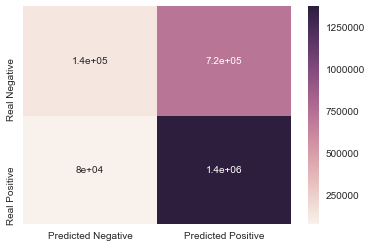

In [70]:
sns.heatmap(lr_cm, annot=True, xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Real Negative','Real Positive']);

In [82]:
TN = lr_cm[0][0]
FP = lr_cm[0][1]
FN = lr_cm[1][0]
TP = lr_cm[1][1]

print("Accuracy (TP+TN/TP+TN+FP+FN):",'{:.2}'.format((TP+TN)/(TP+TN+FP+FN)))
print("Sensitivity (TP/TP+FN):",'{:.2}'.format(TP/(TP+FN)))
print("Specificity (TN/TN+FP):",'{:.2}'.format(TN/(TN+FP)))


Accuracy (TP+TN/TP+TN+FP+FN): 0.65
Sensitivity (TP/TP+FN): 0.94
Specificity (TN/TN+FP): 0.16


This model is slightly better than random, but you could instead guess that all trips were short trips and get 63% accuracy, so this isn't much of an improvement. Of particular note, the model is very bad at detecting long trips.

### Random forest classifier model

The Linear Regression model doesn't perform very well, so I'm goign to try a Random Forest classifier instead. The downside is that it takes longer to train the model, but hopefully model performance will improve?

In [21]:
start = time.mktime(time.localtime())
print("Running...") #so I know Jupyter is doing something

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

duration = time.mktime(time.localtime()) - start
print("Random forest model trained in "+str(duration)+" seconds.") #so I know when Jupyter is done (takes about 750 sec.)
print()
print(rf)

Running...
Random forest model trained in 754.0 seconds.

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [86]:
#save the model
with open('rf_model.pkl', 'wb') as fid:
    pickle.dump(rf, fid)    

#with open('rf_model.pkl', 'rb') as fid: #to load model from file
#    rf = pickle.load(fid)
print("Done!")

Done!


In [88]:
#okay, let's test it
rf_pred_test = rf.predict(X_test)

#tn, fp, fn, tp = confusion_matrix()
rf_cm = confusion_matrix(y_test, rf_pred_test)
print(rf_cm)

[[ 776597   85322]
 [ 144353 1302678]]


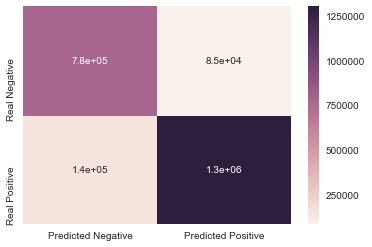

In [89]:
sns.heatmap(rf_cm, annot=True, xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Real Negative','Real Positive']);

In [92]:
TN = rf_cm[0][0]
FP = rf_cm[0][1]
FN = rf_cm[1][0]
TP = rf_cm[1][1]

print("Accuracy (TP+TN/TP+TN+FP+FN):",'{:.2}'.format((TP+TN)/(TP+TN+FP+FN)))
print("Sensitivity (TP/TP+FN):",'{:.2}'.format(TP/(TP+FN)))
print("Specificity (TN/TN+FP):",'{:.2}'.format(TN/(TN+FP)))

Accuracy (TP+TN/TP+TN+FP+FN): 0.9
Sensitivity (TP/TP+FN): 0.9
Specificity (TN/TN+FP): 0.9


The random forest model seems to perform significantly better, with overall accuracy, sensitivity, and specificity all performing at about 90%.